# Calculating common in-source mass differences and selectivity

Development note, related to mass2chem and asari.

This is 1st pass calculation of m/z patterns of a measured compound.

Details dependent on concentration and chemical formula. Only ions of sufficient abundance are observed.
On modern mass spectrometers, mass accuracy can be under 5 ppm. 
For a molecular of 200 Dalton, `200 x 0.000001 x 5ppm = 0.0010`, 
enough to distinguish 1.0034 (13C isotope) from 1.0078 (protonation).

SL 2021-12-27

In [1]:
# from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Isotopes are not dependent on charge; these mass diff can be observed on any ions when the isotopes are present.

# Ratio constraint is loose to leave room for 1) multiple atoms, e.g. 40 C atoms lead to ~ 40*1% in abundance
# 2) measurement errors; not all peaks are in linear dynamic range
# 3) quantification by peak height is not same as peak area

ISOTOPES = [
    # mass diff, isotopes, (intensity ratio constraint)
    (1.003355, '13C/12C', (0, 0.8)),      # 13C-12C, 12C~99%, 13C ~ 1%
    (0.997035, '15N/14N', (0, 0.2)),     # 15N-14N, 14N ~ 99.64%, 15N ~ 0.36%
    (2.004245, '18O/16O', (0, 0.2)),      # 18O-16O, 16O ~ 99.76, 16O ~ 0.2%
    (1.995796, '34S/32S', (0, 0.4)),      # 32S (95.02%), 33S (0.75%), 34S (4.21%)
    (0.999388, '33S/32S', (0, 0.1)),
    # double isotopes
    (2.00039, 'M(13C),M(15N)', (0, 0.2)),
    (2.999151, 'M(13C),M(34S)', (0, 0.4)),
]

common_adducts = {
    # mass diff, modification
    # not using (intensity ratio constraint), but it can be documented or learned
    'pos': [
        (1.0078, 'H'),
        (21.9820, 'Na/H'), # Na replacing H
        (18.0106, '+H2O'), 
        (18.033823, '+NH4'),
        (37.9559, '39K/H'),
        (39.9540, '41K/H'),
        (41.026549, 'Acetonitrile'),
    ],
    'neg': [
        (1.0078, 'H'),
        (22.9893, 'Na'),
        (20.97474706646, '+Na-2H'),
        (18.0106, 'H2O'), 
        (34.9689, '35Cl'),
        (36.9659, '37Cl'),
        (40.01926853323, '+ACN-H'),
        (44.998201, 'COOH'),
        (59.013295, 'CH3COO'),
    ],
}

double_charged = [ # double charged as ad hoc rule to either pos or neg
    (0.5017, '13C/12C, double charged', 0, 0.8),
    (0.4985, '15N/14N, double charged', 0, 0.2),
    (10.991, 'Na/H, double charged'),
]

# to edit later
fragments = [
    (-18.0106, 'H2O'), 
    (-46.005479, 'H2O+CO',{'C':-1 , 'H':-2, 'O':-2 }),
    (-44.99812353323, 'M-HCOOH+H[1+]',{'C': -1, 'H':-1, 'O':-2, }),
    (-42.98252353323, 'M-CO2+H[1+]',{'C':-1 , 'H':1, 'O':-2,}),
    (-35.037114, 'NH3+H2O', {'H':-5, 'O':-1, 'N':-1} ),
    (-35.01392353323, 'M-H4O2+H[1+]',{'H':-3, 'O':-2,}),
    (-26.98772353323, 'M-CO+H[1+]',{'C':-1 , 'H':1, 'O':-1 ,}),
    (-19.01787646677, 'M-H2O-H[-]', {'H':-3, 'O':-1 ,}),
    (-18.010565, 'H2O',{'H':-2, 'O':-1}),
    (-17.026549, 'NH3',{'N':-1 , 'H':-3}),
    (-17.00332353323, 'M-H2O+H[1+]',{'H':-1,'O':-1 ,}),
    (-16.019223533229997, 'M-NH3+H[1+]', {'N': -1, 'H':-2 ,}),
    (-72.0211, '-C3H4O2'),
    ]

In [3]:
# copied from asari

def calculate_selectivity(sorted_mz_list, std_ppm=5):
    '''
    To calculate selectivity for all valid mass traces (thus specific m/z values).

    The mass selectivity between two m/z values, between (0, 1), is defined as: 
    (1 - Probability(confusing two peaks)), further formalized as an exponential model:

    P = exp( -x/std_ppm ),
    whereas x is ppm distance between two peaks, 
    std_ppm standard deviation of ppm between true peaks and theoretical values, default at 5 pmm.

    Close to 1 means high selectivity.
    If multiple adjacent peaks are present, we multiply the selectivity scores.
    Considering 2 lower and 2 higher neighbors approximately here.

    Future direction: std_ppm can be dependent on m/z. 
    This can be taken into account by a higher order model.
    '''
    def __sel__(x, std_ppm=std_ppm): 
        if x > 100:         # too high, not bother
            return 1
        else:
            return 1 - np.exp(-x/std_ppm)

    mz_list = np.array(sorted_mz_list)
    ppm_distances = 1000000 * (mz_list[1:] - mz_list[:-1])/mz_list[:-1]
    # first two MassTraces
    selectivities = [
        __sel__(ppm_distances[0]) * __sel__(ppm_distances[0]+ppm_distances[1]),
        __sel__(ppm_distances[0]) * __sel__(ppm_distances[1])* __sel__(ppm_distances[1]+ppm_distances[2]),
        ]
    for ii in range(2, mz_list.size-2):
        selectivities.append(
            __sel__(ppm_distances[ii-2]+ppm_distances[ii-1]) * __sel__(ppm_distances[ii-1]) * __sel__(ppm_distances[ii]) * __sel__(ppm_distances[ii]+ppm_distances[ii+1])
        )
    # last two MassTraces
    selectivities += [
        __sel__(ppm_distances[-3]+ppm_distances[-2]) * __sel__(ppm_distances[-2]) * __sel__(ppm_distances[-1]),
        __sel__(ppm_distances[-2]+ppm_distances[-1]) * __sel__(ppm_distances[-1]),
        ]

    return selectivities


## Positive ionization table

In [4]:
adducts = common_adducts['pos']
pbase = ISOTOPES + adducts + double_charged
combo = []
# not using all `combinations` here

for x in ISOTOPES:
    for y in adducts:
        combo.append( (x[0]+y[0], x[1] +','+ y[1]) )

pos_all = pbase + combo
pos_all.sort()

In [14]:
pos_all #[:10]

[(0.4985, '15N/14N, double charged', 0, 0.2),
 (0.5017, '13C/12C, double charged', 0, 0.8),
 (0.997035, '15N/14N', (0, 0.2)),
 (0.999388, '33S/32S', (0, 0.1)),
 (1.003355, '13C/12C', (0, 0.8)),
 (1.0078, 'H'),
 (1.995796, '34S/32S', (0, 0.4)),
 (2.00039, 'M(13C),M(15N)'),
 (2.004245, '18O/16O', (0, 0.2)),
 (2.004835, '15N/14N,H'),
 (2.007188, '33S/32S,H'),
 (2.011155, '13C/12C,H'),
 (2.999151, 'M(13C),M(34S)'),
 (3.003596, '34S/32S,H'),
 (3.00819, 'M(13C),M(15N),H'),
 (3.012045, '18O/16O,H'),
 (4.006951, 'M(13C),M(34S),H'),
 (10.991, 'Na/H, double charged'),
 (18.0106, '+H2O'),
 (18.033823, '+NH4'),
 (19.007635, '15N/14N,+H2O'),
 (19.009988, '33S/32S,+H2O'),
 (19.013955, '13C/12C,+H2O'),
 (19.030858000000002, '15N/14N,+NH4'),
 (19.033211, '33S/32S,+NH4'),
 (19.037178, '13C/12C,+NH4'),
 (20.006396, '34S/32S,+H2O'),
 (20.01099, 'M(13C),M(15N),+H2O'),
 (20.014845, '18O/16O,+H2O'),
 (20.029619, '34S/32S,+NH4'),
 (20.034213, 'M(13C),M(15N),+NH4'),
 (20.038068000000003, '18O/16O,+NH4'),
 (21

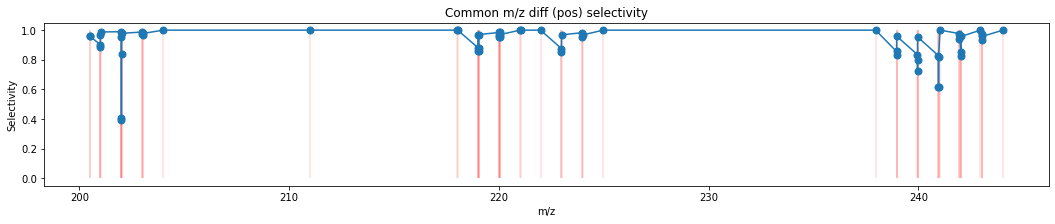

In [6]:
# plot selectivity, assume for an ion ~ 200 

hyperthetical = 200

mzlist = [x[0]+hyperthetical for x in pos_all]
selectivities = calculate_selectivity(mzlist)

plt.figure(figsize=(18,3))
plt.plot(mzlist, selectivities, '-o', markersize=7)
plt.vlines(mzlist, 0, 1, color='r',linewidth=0.2)
plt.xlabel("m/z")
plt.ylabel("Selectivity")
plt.title("Common m/z diff (pos) selectivity")
plt.savefig("Figure_selectivity_200_pos_common_mzdiff.pdf")

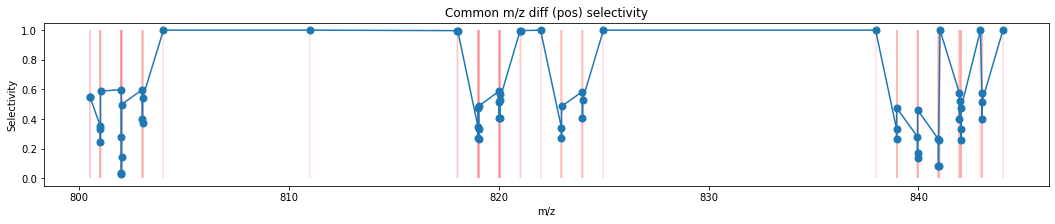

In [7]:
hyperthetical = 800

mzlist = [x[0]+hyperthetical for x in pos_all]
selectivities800 = calculate_selectivity(mzlist)

plt.figure(figsize=(18,3))
plt.plot(mzlist, selectivities800, '-o', markersize=7)
plt.vlines(mzlist, 0, 1, color='r',linewidth=0.2)
plt.xlabel("m/z")
plt.ylabel("Selectivity")
plt.title("Common m/z diff (pos) selectivity")
plt.savefig("Figure_selectivity_800_pos_common_mzdiff.pdf")

In [8]:
# write out selectivity

outlist = []
for ii in range(len(pos_all)):
    outlist.append( [selectivities800[ii], selectivities[ii]] + list(pos_all[ii]) )

outlist.sort(reverse=True)
    
s = 'selectivity_800\tselectivity_200\tmz_diff\tnote\tratio_constraints\n'
for line in outlist:
    xx = '\t'.join( [str(x) for x in line] )
    print(xx)
    s += xx + '\n'
    
with open('selectivity_pos_common_mzdiff.tsv', 'w') as O:
    O.write(s)

1	1	44.0257	M(13C),M(34S),Acetonitrile
1	1	37.9559	39K/H
1	1	24.981151	M(13C),M(34S),Na/H
1	1	21.982	Na/H
1	1	10.991	Na/H, double charged
1	1	4.006951	M(13C),M(34S),H
0.9999999009038226	1	42.953151	M(13C),M(34S),41K/H
0.9999998874381868	1	41.026549	Acetonitrile
0.9965793392097703	1	18.033823	+NH4
0.9965793392097703	1	18.0106	+H2O
0.9965076487856275	1	21.032974000000003	M(13C),M(34S),+NH4
0.9965076487856275	1	21.009751	M(13C),M(34S),+H2O
0.5990489795279155	0.989187779062629	1.995796	34S/32S	(0, 0.4)
0.5990126401793237	0.9873322698564604	2.999151	M(13C),M(34S)
0.5883305826544349	0.9877706425792866	1.0078	H
0.5880492354090212	0.9841892937005656	20.006396	34S/32S,+H2O
0.5856537189137077	0.982943316188848	23.977795999999998	34S/32S,Na/H
0.5749483416950179	0.9766670492591896	41.949796	34S/32S,41K/H
0.5743164059463677	0.9762600175351798	43.022345	34S/32S,Acetonitrile
0.5659380147364126	0.9841806673784697	20.029619	34S/32S,+NH4
0.5504471291111062	0.9589121914626395	0.5017	13C/12C, double charg

### Selectivity is bad for many at 800 amu, but depends on abundance of isotopes too


## Negative ionization table

In [9]:
adducts = common_adducts['neg']
pbase = ISOTOPES + adducts + double_charged
combo = []
# not using all `combinations` here

for x in ISOTOPES:
    for y in adducts:
        combo.append( (x[0]+y[0], x[1] +','+ y[1]) )

neg_all = pbase + combo
neg_all.sort()

In [15]:
neg_all #[:10]

[(0.4985, '15N/14N, double charged', 0, 0.2),
 (0.5017, '13C/12C, double charged', 0, 0.8),
 (0.997035, '15N/14N', (0, 0.2)),
 (0.999388, '33S/32S', (0, 0.1)),
 (1.003355, '13C/12C', (0, 0.8)),
 (1.0078, 'H'),
 (1.995796, '34S/32S', (0, 0.4)),
 (2.00039, 'M(13C),M(15N)'),
 (2.004245, '18O/16O', (0, 0.2)),
 (2.004835, '15N/14N,H'),
 (2.007188, '33S/32S,H'),
 (2.011155, '13C/12C,H'),
 (2.999151, 'M(13C),M(34S)'),
 (3.003596, '34S/32S,H'),
 (3.00819, 'M(13C),M(15N),H'),
 (3.012045, '18O/16O,H'),
 (4.006951, 'M(13C),M(34S),H'),
 (10.991, 'Na/H, double charged'),
 (18.0106, 'H2O'),
 (19.007635, '15N/14N,H2O'),
 (19.009988, '33S/32S,H2O'),
 (19.013955, '13C/12C,H2O'),
 (20.006396, '34S/32S,H2O'),
 (20.01099, 'M(13C),M(15N),H2O'),
 (20.014845, '18O/16O,H2O'),
 (20.97474706646, '+Na-2H'),
 (21.009751, 'M(13C),M(34S),H2O'),
 (21.97178206646, '15N/14N,+Na-2H'),
 (21.97413506646, '33S/32S,+Na-2H'),
 (21.97810206646, '13C/12C,+Na-2H'),
 (22.97054306646, '34S/32S,+Na-2H'),
 (22.97513706646, 'M(13C)

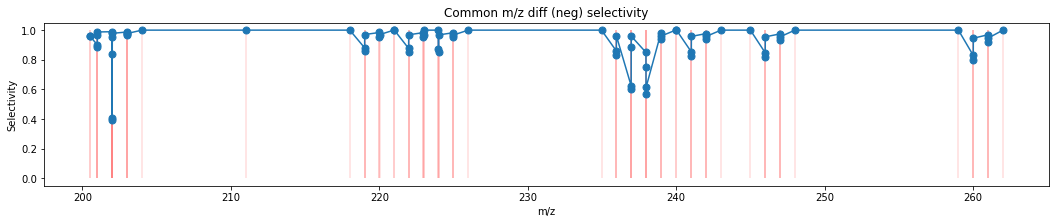

In [11]:
# plot selectivity, assume for an ion ~ 200 

hyperthetical = 200

mzlist = [x[0]+hyperthetical for x in neg_all]
selectivities = calculate_selectivity(mzlist)

plt.figure(figsize=(18,3))
plt.plot(mzlist, selectivities, '-o', markersize=7)
plt.vlines(mzlist, 0, 1, color='r',linewidth=0.2)
plt.xlabel("m/z")
plt.ylabel("Selectivity")
plt.title("Common m/z diff (neg) selectivity")
plt.savefig("Figure_selectivity_200_neg_common_mzdiff.pdf")

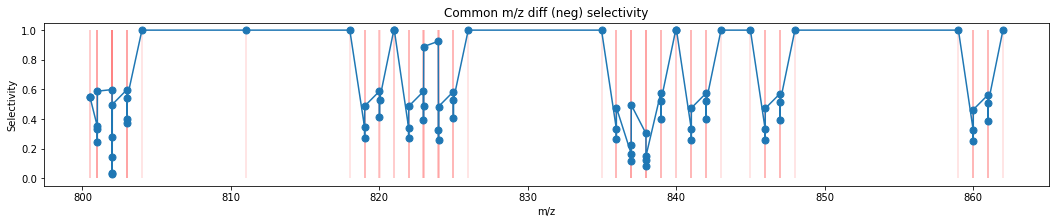

In [12]:
hyperthetical = 800

mzlist = [x[0]+hyperthetical for x in neg_all]
selectivities800 = calculate_selectivity(mzlist)

plt.figure(figsize=(18,3))
plt.plot(mzlist, selectivities800, '-o', markersize=7)
plt.vlines(mzlist, 0, 1, color='r',linewidth=0.2)
plt.xlabel("m/z")
plt.ylabel("Selectivity")
plt.title("Common m/z diff (neg) selectivity")
plt.savefig("Figure_selectivity_800_neg_common_mzdiff.pdf")

In [13]:
# write out selectivity
outlist = []
for ii in range(len(pos_all)):
    outlist.append( [selectivities800[ii], selectivities[ii]] + list(pos_all[ii]) )

outlist.sort(reverse=True)
s = 'selectivity_800\tselectivity_200\tmz_diff\tnote\tratio_constraints\n'
for line in outlist:
    xx = '\t'.join( [str(x) for x in line] )
    print(xx)
    s += xx + '\n'

with open('selectivity_neg_common_mzdiff.tsv', 'w') as O:
    O.write(s)

1	1	44.0257	M(13C),M(34S),Acetonitrile
1	1	37.9559	39K/H
1	1	24.981151	M(13C),M(34S),Na/H
1	1	18.0106	+H2O
1	1	10.991	Na/H, double charged
1	1	4.006951	M(13C),M(34S),H
0.9999975255034438	1	42.023584	15N/14N,Acetonitrile
0.9999975255034438	1	41.958245	18O/16O,41K/H
0.999802032582712	1	20.006396	34S/32S,+H2O
0.999802032582712	1	19.037178	13C/12C,+NH4
0.9248860604098961	0.9999831353781108	21.982	Na/H
0.88893609790201	0.9999004294231247	21.032974000000003	M(13C),M(34S),+NH4
0.5990489795279155	0.989187779062629	1.995796	34S/32S	(0, 0.4)
0.5990126401793237	0.9873322698564604	2.999151	M(13C),M(34S)
0.5883305826544349	0.9877706425792866	1.0078	H
0.5880492354090212	0.9841892937005656	19.013955	13C/12C,+H2O
0.5862602613443765	0.9832642141756823	20.034213	M(13C),M(15N),+NH4
0.5850478442886066	0.9826190913236883	23.977795999999998	34S/32S,Na/H
0.576712931902452	0.9777819926070552	41.026549	Acetonitrile
0.5749098662110523	0.9766423827407362	43.022345	34S/32S,Acetonitrile
0.5504471291111062	0.958912

## Summary

- Selectivity here is highly m/z dependent
- Will select a subset manually in downstream applications
